In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# Federated learning hyperparameters
num_epochs, learning_rate = 5, 0.001
batch_sizes, communication_rounds = [64, 128], 100
overlap_percentage = 25 # Dmeta hyperparameter

In [3]:
# Define a deep learning model (CNN)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Modify the architecture based on your requirements
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [4]:
# Dataset preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Assuming you have the FEMNIST dataset downloaded and split for each client
# Replace 'path_to_client_data' with the actual path to the client data
client_dataset = torchvision.datasets.FashionMNIST(root='path_to_client_data', train=True, download=True, transform=transform)

# Split the client dataset into train and validation sets
train_size = int(0.8 * len(client_dataset))
val_size = len(client_dataset) - train_size
client_train_set, client_val_set = random_split(client_dataset, [train_size, val_size])

# DataLoader for training and validation
train_loaders = [DataLoader(client_train_set, batch_size=batch_size, shuffle=True, num_workers=4) for batch_size in batch_sizes]
val_loader = DataLoader(client_val_set, batch_size=batch_sizes[0], shuffle=False, num_workers=4)

In [5]:
# Function to train the model for a given federated learning algorithm
def train_federated_learning_with_dmeta(model, train_loader, dmeta_loader, algorithm_name):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    performance_metrics = {'accuracy': [], 'loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Train on D
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name} - D'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Train on Dmeta
        for images, labels in tqdm(dmeta_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name} - Dmeta'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss at the end of each epoch
        average_loss = running_loss / (len(train_loader) + len(dmeta_loader))
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Loss: {average_loss:.4f}')

        # Evaluate on validation set
        accuracy = evaluate_model(model, val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Validation Accuracy: {accuracy * 100:.2f}%')

        performance_metrics['accuracy'].append(accuracy)
        performance_metrics['loss'].append(average_loss)

    return performance_metrics

# Function to evaluate the model on the validation set
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [6]:
# def train_federated_learningAdj(model, train_loader, algorithm_name, times):
#     model.train()
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
#     # Initialize the convolutional layer outside the loop
#     in_channels = train_loader.dataset[0][0].shape[0]  # Number of input channels
#     out_channels = max(1, in_channels - times) 
#     conv_reduce_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
#     performance_metrics = {'accuracy': [], 'loss': []}

#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name}'):
#             images, labels = images.to(device), labels.to(device)
            
#             # Apply the convolutional layer to input images
#             data = conv_reduce_channels(images)
            
#             optimizer.zero_grad()
#             outputs = model(data)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         # Print average loss at the end of each epoch
#         average_loss = running_loss / len(train_loader)
#         print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Loss: {average_loss:.4f}')

#         # Evaluate on validation set
#         accuracy = evaluate_model(model, val_loader)
#         print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Validation Accuracy: {accuracy * 100:.2f}%')

#         performance_metrics['accuracy'].append(accuracy)
#         performance_metrics['loss'].append(average_loss)

#     return performance_metrics

# Function to train the model for a given federated learning algorithm
def train_federated_learning_with_dmetaAdj(model, train_loader, dmeta_loader, algorithm_name, times):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
     # Initialize the convolutional layer outside the loop
    in_channels = train_loader.dataset[0][0].shape[0]
    out_channels = max(1, in_channels - times) 
    conv_reduce_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    performance_metrics = {'accuracy': [], 'loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Train on D
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name} - D'):
            images, labels = images.to(device), labels.to(device)

            data = conv_reduce_channels(images)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Train on Dmeta
        for images, labels in tqdm(dmeta_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name} - Dmeta'):
            images, labels = images.to(device), labels.to(device)

            data = conv_reduce_channels(images)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss at the end of each epoch
        average_loss = running_loss / (len(train_loader) + len(dmeta_loader))
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Loss: {average_loss:.4f}')

        # Evaluate on validation set
        accuracy = evaluate_model(model, val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Validation Accuracy: {accuracy * 100:.2f}%')

        performance_metrics['accuracy'].append(accuracy)
        performance_metrics['loss'].append(average_loss)

    return performance_metrics

# Function to evaluate the model on the validation set
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy



In [7]:
# Number of writers in Dmeta
num_writers_dmeta = int(overlap_percentage / 100 * len(client_dataset))

# Select writers from D and the auxiliary dataset
writers_d = client_dataset.targets.unique().tolist()
writers_auxiliary = list(range(100))  # Assuming 100 writers in the auxiliary dataset

# Select a certain proportion of writers from D and the rest from the auxiliary dataset
selected_writers_d = writers_d[:len(writers_d) - num_writers_dmeta]
selected_writers_auxiliary = writers_auxiliary[:num_writers_dmeta]

# Combine selected writers to form Dmeta writers
writers_dmeta = selected_writers_d + selected_writers_auxiliary

# Sample 1% examples to form Dmeta
num_samples_dmeta = int(.5 * len(client_dataset))
indices_dmeta = torch.randperm(len(client_dataset))[:num_samples_dmeta]

# Create Dmeta by selecting examples from D and auxiliary dataset
data_dmeta = [client_dataset[i] for i in indices_dmeta]
dmeta_loader = DataLoader(data_dmeta, batch_size=batch_sizes[0], shuffle=True, num_workers=4)

In [8]:
fedmeta_model = CNNModel().to(device)
# Train & Evaluate FedMeta w/ UGA
fedmeta_uga_performance_dmeta = train_federated_learning_with_dmeta(fedmeta_model, train_loaders[0], dmeta_loader, 'FedMeta w/ UGA with Dmeta')

Epoch 1/5 - FedMeta w/ UGA with Dmeta - Dmeta: 100%|██████████| 469/469 [01:23<00:00,  5.59it/s]


Epoch [1/5] - FedMeta w/ UGA with Dmeta, Loss: 0.3720
Epoch [1/5] - FedMeta w/ UGA with Dmeta, Validation Accuracy: 91.05%


Epoch 2/5 - FedMeta w/ UGA with Dmeta - Dmeta: 100%|██████████| 469/469 [01:18<00:00,  5.95it/s]


Epoch [2/5] - FedMeta w/ UGA with Dmeta, Loss: 0.2245
Epoch [2/5] - FedMeta w/ UGA with Dmeta, Validation Accuracy: 91.14%


Epoch 3/5 - FedMeta w/ UGA with Dmeta - Dmeta: 100%|██████████| 469/469 [00:36<00:00, 12.73it/s]


Epoch [3/5] - FedMeta w/ UGA with Dmeta, Loss: 0.1693
Epoch [3/5] - FedMeta w/ UGA with Dmeta, Validation Accuracy: 93.18%


Epoch 4/5 - FedMeta w/ UGA with Dmeta - Dmeta: 100%|██████████| 469/469 [00:35<00:00, 13.05it/s]


Epoch [4/5] - FedMeta w/ UGA with Dmeta, Loss: 0.1247
Epoch [4/5] - FedMeta w/ UGA with Dmeta, Validation Accuracy: 94.33%


Epoch 5/5 - FedMeta w/ UGA with Dmeta - Dmeta: 100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [5/5] - FedMeta w/ UGA with Dmeta, Loss: 0.0906
Epoch [5/5] - FedMeta w/ UGA with Dmeta, Validation Accuracy: 94.88%


In [9]:
fedmeta_model2 = CNNModel().to(device)
fedmeta_uga_performance_dmeta2 = train_federated_learning_with_dmetaAdj(fedmeta_model2, train_loaders[0], dmeta_loader, 'FedMeta w/ UGA with Dmeta(100 Removed Nodes)', 100)

Epoch 1/5 - FedMeta w/ UGA with Dmeta(100 Removed Nodes) - D:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/5 - FedMeta w/ UGA with Dmeta(100 Removed Nodes) - D: 100%|██████████| 750/750 [01:42<00:00,  7.33it/s]
Epoch 1/5 - FedMeta w/ UGA with Dmeta(100 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [01:58<00:00,  3.95it/s]


Epoch [1/5] - FedMeta w/ UGA with Dmeta(100 Removed Nodes), Loss: 0.3775
Epoch [1/5] - FedMeta w/ UGA with Dmeta(100 Removed Nodes), Validation Accuracy: 22.99%


Epoch 2/5 - FedMeta w/ UGA with Dmeta(100 Removed Nodes) - D: 100%|██████████| 750/750 [02:41<00:00,  4.64it/s]
Epoch 2/5 - FedMeta w/ UGA with Dmeta(100 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]


Epoch [2/5] - FedMeta w/ UGA with Dmeta(100 Removed Nodes), Loss: 0.2352
Epoch [2/5] - FedMeta w/ UGA with Dmeta(100 Removed Nodes), Validation Accuracy: 23.62%


Epoch 3/5 - FedMeta w/ UGA with Dmeta(100 Removed Nodes) - D: 100%|██████████| 750/750 [02:54<00:00,  4.30it/s]
Epoch 3/5 - FedMeta w/ UGA with Dmeta(100 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:20<00:00,  3.34it/s]


Epoch [3/5] - FedMeta w/ UGA with Dmeta(100 Removed Nodes), Loss: 0.1778
Epoch [3/5] - FedMeta w/ UGA with Dmeta(100 Removed Nodes), Validation Accuracy: 22.02%


Epoch 4/5 - FedMeta w/ UGA with Dmeta(100 Removed Nodes) - D: 100%|██████████| 750/750 [02:54<00:00,  4.30it/s]
Epoch 4/5 - FedMeta w/ UGA with Dmeta(100 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:08<00:00,  3.64it/s]


Epoch [4/5] - FedMeta w/ UGA with Dmeta(100 Removed Nodes), Loss: 0.1351
Epoch [4/5] - FedMeta w/ UGA with Dmeta(100 Removed Nodes), Validation Accuracy: 17.78%


Epoch 5/5 - FedMeta w/ UGA with Dmeta(100 Removed Nodes) - D: 100%|██████████| 750/750 [02:53<00:00,  4.33it/s]
Epoch 5/5 - FedMeta w/ UGA with Dmeta(100 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:07<00:00,  3.69it/s]


Epoch [5/5] - FedMeta w/ UGA with Dmeta(100 Removed Nodes), Loss: 0.1022
Epoch [5/5] - FedMeta w/ UGA with Dmeta(100 Removed Nodes), Validation Accuracy: 22.25%


In [10]:
fedmeta_model3 = CNNModel().to(device)
fedmeta_uga_performance_dmeta3 = train_federated_learning_with_dmetaAdj(fedmeta_model3, train_loaders[0], dmeta_loader, 'FedMeta w/ UGA with Dmeta(200 Removed Nodes)', 200)

Epoch 1/5 - FedMeta w/ UGA with Dmeta(200 Removed Nodes) - D:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/5 - FedMeta w/ UGA with Dmeta(200 Removed Nodes) - D: 100%|██████████| 750/750 [02:35<00:00,  4.83it/s]
Epoch 1/5 - FedMeta w/ UGA with Dmeta(200 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:08<00:00,  3.64it/s]


Epoch [1/5] - FedMeta w/ UGA with Dmeta(200 Removed Nodes), Loss: 0.4024
Epoch [1/5] - FedMeta w/ UGA with Dmeta(200 Removed Nodes), Validation Accuracy: 75.58%


Epoch 2/5 - FedMeta w/ UGA with Dmeta(200 Removed Nodes) - D: 100%|██████████| 750/750 [02:58<00:00,  4.19it/s]
Epoch 2/5 - FedMeta w/ UGA with Dmeta(200 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:12<00:00,  3.54it/s]


Epoch [2/5] - FedMeta w/ UGA with Dmeta(200 Removed Nodes), Loss: 0.2436
Epoch [2/5] - FedMeta w/ UGA with Dmeta(200 Removed Nodes), Validation Accuracy: 74.33%


Epoch 3/5 - FedMeta w/ UGA with Dmeta(200 Removed Nodes) - D: 100%|██████████| 750/750 [02:56<00:00,  4.24it/s]
Epoch 3/5 - FedMeta w/ UGA with Dmeta(200 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:12<00:00,  3.53it/s]


Epoch [3/5] - FedMeta w/ UGA with Dmeta(200 Removed Nodes), Loss: 0.1880
Epoch [3/5] - FedMeta w/ UGA with Dmeta(200 Removed Nodes), Validation Accuracy: 74.78%


Epoch 4/5 - FedMeta w/ UGA with Dmeta(200 Removed Nodes) - D: 100%|██████████| 750/750 [02:59<00:00,  4.18it/s]
Epoch 4/5 - FedMeta w/ UGA with Dmeta(200 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:20<00:00,  3.33it/s]


Epoch [4/5] - FedMeta w/ UGA with Dmeta(200 Removed Nodes), Loss: 0.1480
Epoch [4/5] - FedMeta w/ UGA with Dmeta(200 Removed Nodes), Validation Accuracy: 79.38%


Epoch 5/5 - FedMeta w/ UGA with Dmeta(200 Removed Nodes) - D: 100%|██████████| 750/750 [02:59<00:00,  4.19it/s]
Epoch 5/5 - FedMeta w/ UGA with Dmeta(200 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:13<00:00,  3.50it/s]


Epoch [5/5] - FedMeta w/ UGA with Dmeta(200 Removed Nodes), Loss: 0.1119
Epoch [5/5] - FedMeta w/ UGA with Dmeta(200 Removed Nodes), Validation Accuracy: 78.79%


In [11]:
fedmeta_model4 = CNNModel().to(device)
fedmeta_uga_performance_dmeta4 = train_federated_learning_with_dmetaAdj(fedmeta_model4, train_loaders[0], dmeta_loader, 'FedMeta w/ UGA with Dmeta(400 Removed Nodes)', 400)

Epoch 1/5 - FedMeta w/ UGA with Dmeta(400 Removed Nodes) - D:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/5 - FedMeta w/ UGA with Dmeta(400 Removed Nodes) - D: 100%|██████████| 750/750 [02:32<00:00,  4.92it/s]
Epoch 1/5 - FedMeta w/ UGA with Dmeta(400 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:13<00:00,  3.52it/s]


Epoch [1/5] - FedMeta w/ UGA with Dmeta(400 Removed Nodes), Loss: 0.3952
Epoch [1/5] - FedMeta w/ UGA with Dmeta(400 Removed Nodes), Validation Accuracy: 13.04%


Epoch 2/5 - FedMeta w/ UGA with Dmeta(400 Removed Nodes) - D: 100%|██████████| 750/750 [02:53<00:00,  4.33it/s]
Epoch 2/5 - FedMeta w/ UGA with Dmeta(400 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:09<00:00,  3.61it/s]


Epoch [2/5] - FedMeta w/ UGA with Dmeta(400 Removed Nodes), Loss: 0.2380
Epoch [2/5] - FedMeta w/ UGA with Dmeta(400 Removed Nodes), Validation Accuracy: 14.37%


Epoch 3/5 - FedMeta w/ UGA with Dmeta(400 Removed Nodes) - D: 100%|██████████| 750/750 [02:54<00:00,  4.29it/s]
Epoch 3/5 - FedMeta w/ UGA with Dmeta(400 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:07<00:00,  3.68it/s]


Epoch [3/5] - FedMeta w/ UGA with Dmeta(400 Removed Nodes), Loss: 0.1873
Epoch [3/5] - FedMeta w/ UGA with Dmeta(400 Removed Nodes), Validation Accuracy: 15.27%


Epoch 4/5 - FedMeta w/ UGA with Dmeta(400 Removed Nodes) - D: 100%|██████████| 750/750 [02:51<00:00,  4.37it/s]
Epoch 4/5 - FedMeta w/ UGA with Dmeta(400 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:08<00:00,  3.66it/s]


Epoch [4/5] - FedMeta w/ UGA with Dmeta(400 Removed Nodes), Loss: 0.1472
Epoch [4/5] - FedMeta w/ UGA with Dmeta(400 Removed Nodes), Validation Accuracy: 15.43%


Epoch 5/5 - FedMeta w/ UGA with Dmeta(400 Removed Nodes) - D: 100%|██████████| 750/750 [02:48<00:00,  4.45it/s]
Epoch 5/5 - FedMeta w/ UGA with Dmeta(400 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch [5/5] - FedMeta w/ UGA with Dmeta(400 Removed Nodes), Loss: 0.1118
Epoch [5/5] - FedMeta w/ UGA with Dmeta(400 Removed Nodes), Validation Accuracy: 14.00%


In [12]:
fedmeta_model5 = CNNModel().to(device)
fedmeta_uga_performance_dmeta5 = train_federated_learning_with_dmetaAdj(fedmeta_model5, train_loaders[0], dmeta_loader, 'FedMeta w/ UGA with Dmeta(800 Removed Nodes)', 800)

Epoch 1/5 - FedMeta w/ UGA with Dmeta(800 Removed Nodes) - D:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/5 - FedMeta w/ UGA with Dmeta(800 Removed Nodes) - D: 100%|██████████| 750/750 [02:37<00:00,  4.75it/s]
Epoch 1/5 - FedMeta w/ UGA with Dmeta(800 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:17<00:00,  3.41it/s]


Epoch [1/5] - FedMeta w/ UGA with Dmeta(800 Removed Nodes), Loss: 0.3760
Epoch [1/5] - FedMeta w/ UGA with Dmeta(800 Removed Nodes), Validation Accuracy: 17.61%


Epoch 2/5 - FedMeta w/ UGA with Dmeta(800 Removed Nodes) - D: 100%|██████████| 750/750 [02:50<00:00,  4.40it/s]
Epoch 2/5 - FedMeta w/ UGA with Dmeta(800 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:07<00:00,  3.67it/s]


Epoch [2/5] - FedMeta w/ UGA with Dmeta(800 Removed Nodes), Loss: 0.2307
Epoch [2/5] - FedMeta w/ UGA with Dmeta(800 Removed Nodes), Validation Accuracy: 18.71%


Epoch 3/5 - FedMeta w/ UGA with Dmeta(800 Removed Nodes) - D: 100%|██████████| 750/750 [02:48<00:00,  4.44it/s]
Epoch 3/5 - FedMeta w/ UGA with Dmeta(800 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:14<00:00,  3.48it/s]


Epoch [3/5] - FedMeta w/ UGA with Dmeta(800 Removed Nodes), Loss: 0.1754
Epoch [3/5] - FedMeta w/ UGA with Dmeta(800 Removed Nodes), Validation Accuracy: 22.05%


Epoch 4/5 - FedMeta w/ UGA with Dmeta(800 Removed Nodes) - D: 100%|██████████| 750/750 [02:53<00:00,  4.32it/s]
Epoch 4/5 - FedMeta w/ UGA with Dmeta(800 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:03<00:00,  3.78it/s]


Epoch [4/5] - FedMeta w/ UGA with Dmeta(800 Removed Nodes), Loss: 0.1332
Epoch [4/5] - FedMeta w/ UGA with Dmeta(800 Removed Nodes), Validation Accuracy: 22.96%


Epoch 5/5 - FedMeta w/ UGA with Dmeta(800 Removed Nodes) - D: 100%|██████████| 750/750 [02:53<00:00,  4.32it/s]
Epoch 5/5 - FedMeta w/ UGA with Dmeta(800 Removed Nodes) - Dmeta: 100%|██████████| 469/469 [02:06<00:00,  3.71it/s]


Epoch [5/5] - FedMeta w/ UGA with Dmeta(800 Removed Nodes), Loss: 0.1011
Epoch [5/5] - FedMeta w/ UGA with Dmeta(800 Removed Nodes), Validation Accuracy: 19.55%


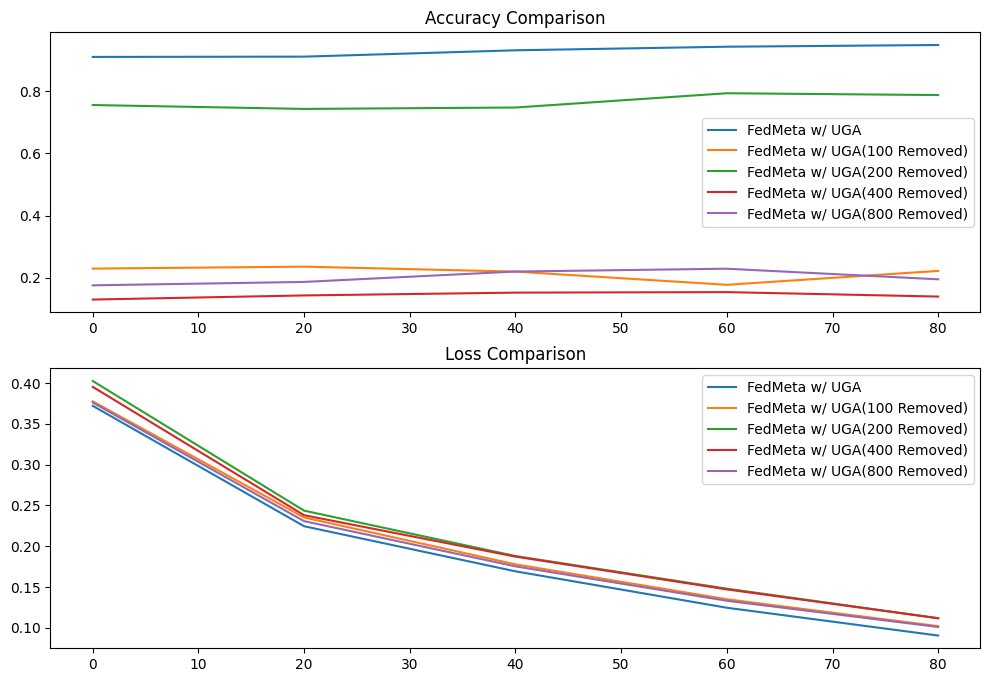

In [13]:
# Create comparison plots for FEMNIST
plt.figure(figsize=(12, 8))

# Test accuracy comparison
plt.subplot(2, 1, 1)
plt.title("Accuracy Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta['accuracy'], label='FedMeta w/ UGA')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta2['accuracy'], label='FedMeta w/ UGA(100 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta3['accuracy'], label='FedMeta w/ UGA(200 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta4['accuracy'], label='FedMeta w/ UGA(400 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta5['accuracy'], label='FedMeta w/ UGA(800 Removed)')


# Loss comparison
plt.subplot(2, 1, 2)
plt.title("Loss Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta['loss'], label='FedMeta w/ UGA')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta2['loss'], label='FedMeta w/ UGA(100 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta3['loss'], label='FedMeta w/ UGA(200 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta4['loss'], label='FedMeta w/ UGA(400 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta5['loss'], label='FedMeta w/ UGA(800 Removed)')

plt.show()